In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('/home/hrai/codes/PoseAdaptor/')
from lib_import import *
from my_utils import *
import torch

In [6]:
a = torch.ones(16, 243, 9, 3) 
for i in range(9):
    a[:, :, i] *= i
b = torch.ones(16, 243, 9, 3)

In [13]:
joint0 = a[:, :, 0].unsqueeze(2)
joint1 = a[:, :, 1].unsqueeze(2)
joint2 = a[:, :, 2].unsqueeze(2)
joint3 = a[:, :, 3].unsqueeze(2)
joint4 = a[:, :, 4].unsqueeze(2)
torch.cat([joint0, joint4, joint2, joint1, joint3], dim=2)

tensor([[[[0., 0., 0.],
          [4., 4., 4.],
          [2., 2., 2.],
          [1., 1., 1.],
          [3., 3., 3.]],

         [[0., 0., 0.],
          [4., 4., 4.],
          [2., 2., 2.],
          [1., 1., 1.],
          [3., 3., 3.]],

         [[0., 0., 0.],
          [4., 4., 4.],
          [2., 2., 2.],
          [1., 1., 1.],
          [3., 3., 3.]],

         ...,

         [[0., 0., 0.],
          [4., 4., 4.],
          [2., 2., 2.],
          [1., 1., 1.],
          [3., 3., 3.]],

         [[0., 0., 0.],
          [4., 4., 4.],
          [2., 2., 2.],
          [1., 1., 1.],
          [3., 3., 3.]],

         [[0., 0., 0.],
          [4., 4., 4.],
          [2., 2., 2.],
          [1., 1., 1.],
          [3., 3., 3.]]],


        [[[0., 0., 0.],
          [4., 4., 4.],
          [2., 2., 2.],
          [1., 1., 1.],
          [3., 3., 3.]],

         [[0., 0., 0.],
          [4., 4., 4.],
          [2., 2., 2.],
          [1., 1., 1.],
          [3., 3., 3.]],

       

### Load dataset

In [2]:
h36m_3d_world, h36m_cam_param = load_h36m()

subject = 'S1'
action = 'Walking'
subject_list = h36m_3d_world._data.keys()
action_list = h36m_3d_world._data[subject].keys()
pose3d_s1_walking = h36m_3d_world._data[subject][action]['positions'] # 3d skeleton sequence wrt world CS
cam_info_s1_walking = h36m_3d_world._data[subject][action]['cameras']
cam_param_s1_walking = get_cam_param(cam_info_s1_walking, subject, h36m_cam_param)

# camera parameters
W, H = cam_param_s1_walking['54138969']['W'], cam_param_s1_walking['54138969']['H']
cam_54138969_ext = cam_param_s1_walking['54138969']['ext']
cam_54138969_int = cam_param_s1_walking['54138969']['int']
cam_54138969_proj = cam_param_s1_walking['54138969']['proj']
cam_54138969_origin = cam_param_s1_walking['54138969']['C']

# 3d trajectory
torso_trajectory = get_part_traj(pose3d_s1_walking, 'torso')
pelvis_trajectory = get_part_traj(pose3d_s1_walking, 'pelvis')
l_hip_trajectory = get_part_traj(pose3d_s1_walking, 'l_hip')
l_shoulder_trajectory = get_part_traj(pose3d_s1_walking, 'l_shoulder')
r_shoulder_trajectory = get_part_traj(pose3d_s1_walking, 'r_shoulder')
r_hip_trajectory = get_part_traj(pose3d_s1_walking, 'r_hip')
lower_line_trajectory = get_part_traj(pose3d_s1_walking, 'lower_line')

# World frame
world_frame = generate_world_frame()

==> Loading 3D data wrt World CS...


### Collect arm data

In [3]:
# 각 pose로부터 root_point, upper_vector, under_vector 모으기
l_shoulder_idx = get_h36m_keypoint_index('L_Shoulder')
r_shoulder_idx = get_h36m_keypoint_index('R_Shoulder')
l_hip_idx = get_h36m_keypoint_index('L_Hip')
r_hip_idx = get_h36m_keypoint_index('R_Hip')

root_point_traj_list = []
upper_vector_traj_list = []
under_vector_traj_list = []
for subject in subject_list:
    print(subject)
    action_list = h36m_3d_world._data[subject].keys()
    for action in action_list:
        print(action)
        pose_3d_world = h36m_3d_world._data[subject][action]['positions'] # 3d skeleton sequence wrt world CS
        l_shoulder_trajectory = get_part_traj(pose_3d_world, 'l_shoulder')[:, 0, :]
        r_shoulder_trajectory = get_part_traj(pose_3d_world, 'r_shoulder')[:, 0, :]
        l_hip_trajectory = get_part_traj(pose_3d_world, 'l_hip')[:, 0, :]
        r_hip_trajectory = get_part_traj(pose_3d_world, 'r_hip')[:, 0, :]
        l_elbow_trajectory = get_part_traj(pose_3d_world, 'l_elbow')[:, 0, :]
        r_elbow_trajectory = get_part_traj(pose_3d_world, 'r_elbow')[:, 0, :]
        l_wrist_trajectory = get_part_traj(pose_3d_world, 'l_wrist')[:, 0, :]
        r_wrist_trajectory = get_part_traj(pose_3d_world, 'r_wrist')[:, 0, :]
        l_knee_trajectory = get_part_traj(pose_3d_world, 'l_knee')[:, 0, :]
        r_knee_trajectory = get_part_traj(pose_3d_world, 'r_knee')[:, 0, :]
        l_ankle_trajectory = get_part_traj(pose_3d_world, 'l_ankle')[:, 0, :]
        r_ankle_trajectory = get_part_traj(pose_3d_world, 'r_ankle')[:, 0, :]

        l_arm_upper_vector_trajectory = l_elbow_trajectory - l_shoulder_trajectory
        r_arm_upper_vector_trajectory = r_elbow_trajectory - r_shoulder_trajectory
        l_arm_under_vector_trajectory = l_wrist_trajectory - l_elbow_trajectory
        r_arm_under_vector_trajectory = r_wrist_trajectory - r_elbow_trajectory
        l_leg_upper_vector_trajectory = l_knee_trajectory - l_hip_trajectory
        r_leg_upper_vector_trajectory = r_knee_trajectory - r_hip_trajectory
        l_leg_under_vector_trajectory = l_ankle_trajectory - l_knee_trajectory
        r_leg_under_vector_trajectory = r_ankle_trajectory - r_knee_trajectory

        root_point_traj_list.append(l_shoulder_trajectory)
        root_point_traj_list.append(r_shoulder_trajectory)
        root_point_traj_list.append(l_hip_trajectory)
        root_point_traj_list.append(r_hip_trajectory)
        upper_vector_traj_list.append(l_arm_upper_vector_trajectory)
        upper_vector_traj_list.append(r_arm_upper_vector_trajectory)
        upper_vector_traj_list.append(l_leg_upper_vector_trajectory)
        upper_vector_traj_list.append(r_leg_upper_vector_trajectory)
        under_vector_traj_list.append(l_arm_under_vector_trajectory)
        under_vector_traj_list.append(r_arm_under_vector_trajectory)
        under_vector_traj_list.append(l_leg_under_vector_trajectory)
        under_vector_traj_list.append(r_leg_under_vector_trajectory)

        #break
    #break

S1
Waiting 1
Photo 1
Smoking
Eating 2
WalkTogether 1
Greeting 1
Phoning
Phoning 1
Smoking 1
Discussion 1
WalkTogether
Sitting 1
SittingDown
Directions
Directions 1
Purchases
SittingDown 2
Walking 1
WalkDog 1
Waiting
Walking
Discussion
Eating
Posing
Greeting
Posing 1
WalkDog
Photo
Purchases 1
Sitting 2
S5
Waiting 1
Sitting
Waiting 2
Smoking
WalkTogether 1
Discussion 2
Greeting 1
Directions 2
Phoning
Phoning 1
Smoking 1
Greeting 2
WalkTogether
Sitting 1
SittingDown
SittingDown 1
Discussion 3
Directions 1
Purchases
Walking 1
WalkDog 1
Walking
Eating
Photo 2
Posing
Posing 1
WalkDog
Photo
Purchases 1
Eating 1
S6
Posing 2
Photo 1
Smoking
Eating 2
WalkTogether 1
Greeting 1
Phoning
Phoning 1
Smoking 1
Discussion 1
WalkTogether
Sitting 1
SittingDown
Directions
SittingDown 1
Directions 1
Purchases
Walking 1
WalkDog 1
Waiting
Walking
Discussion
Posing
Greeting
Waiting 3
WalkDog
Photo
Purchases 1
Eating 1
Sitting 2
S7
Waiting 1
Sitting
Photo 1
Waiting 2
Smoking
WalkTogether 1
Greeting 1
Phoning 2


In [4]:
len(root_point_traj_list), len(upper_vector_traj_list), len(under_vector_traj_list)

(836, 836, 836)

In [5]:
# camera parameters
cam_param = {}
for camera_id in ['54138969', '55011271', '58860488', '60457274']:
    cam_param[camera_id] = {}
    cam_param[camera_id]['proj'] = cam_param_s1_walking[camera_id]['proj']
    cam_param[camera_id]['ext'] = cam_param_s1_walking[camera_id]['ext']
    cam_param[camera_id]['int'] = cam_param_s1_walking[camera_id]['int']
    cam_param[camera_id]['origin'] = cam_param_s1_walking[camera_id]['C']
    cam_param[camera_id]['W'] = cam_param_s1_walking[camera_id]['W']
    cam_param[camera_id]['H'] = cam_param_s1_walking[camera_id]['H']
    cam_param[camera_id]['frame'] = generate_camera_frame(cam_param[camera_id]['ext'], name=camera_id)

### Data augmentation

In [296]:
# sampling 
random.seed(0)
total_num_data = 100


for i in tqdm(range(total_num_data)):
    root_point_traj_num = random.randint(0, len(root_point_traj_list)-1)
    upper_vector_traj_num = random.randint(0, len(upper_vector_traj_list)-1)
    under_vector_traj_num = random.randint(0, len(under_vector_traj_list)-1)
    #print(root_point_traj_num, upper_vector_traj_num, under_vector_traj_num)

    root_point_start_idx = random.randint(0, len(root_point_traj_list)-243)
    upper_vector_start_idx = random.randint(0, len(upper_vector_traj_list)-243)
    under_vector_start_idx = random.randint(0, len(under_vector_traj_list)-243)
    #root_point_start_idx, len(root_point_traj_list[root_point_start_idx:root_point_start_idx+243])

    root_point_traj = root_point_traj_list[root_point_traj_num][root_point_start_idx:root_point_start_idx+243]
    #print(len(root_point_traj))
    #print(upper_vector_start_idx, upper_vector_start_idx+243, len(upper_vector_traj_list[upper_vector_traj_num]), len(upper_vector_traj_list))
    upper_vector_traj = upper_vector_traj_list[upper_vector_traj_num][upper_vector_start_idx:upper_vector_start_idx+243] + root_point_traj
    #print(under_vector_start_idx, under_vector_start_idx+243, len(under_vector_traj_list), under_vector_traj_num)
    under_vector_traj = under_vector_traj_list[under_vector_traj_num][under_vector_start_idx:under_vector_start_idx+243] + upper_vector_traj

    limb_trajectory = np.stack([root_point_traj, upper_vector_traj, under_vector_traj], axis=1)
    #limb_trajectory_projected1 = projection(limb_trajectory, cam_param['54138969']['proj'])
    #limb_trajectory_projected2 = projection(limb_trajectory, cam_param['55011271']['proj'])
    #limb_trajectory_projected3 = projection(limb_trajectory, cam_param['58860488']['proj'])
    #limb_trajectory_projected4 = projection(limb_trajectory, cam_param['60457274']['proj'])
    
    # video_path = '/home/hrai/codes/MotionBERT/custom_codes/DHDST/random_limb_sample{}.mp4'.format(i)
    # if os.path.exists(video_path): continue
    # save_h36m_pose_video(limb_trajectory, video_path, dataset='limb', W=None, H=None, pose_type='3d', fps=30,
    #                         xlim=(-1, 1), ylim=(-1, 1), zlim=(0, 2), view=(0, 45),
    #                         centered_xy=False, cam_space=False, on_ground=False, refine_tilt=False,  
    #                         dynamic_view=True, dual_view=False,
    #                         imgs=None,
    #                         show_axis=False)
    #break

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 99.71it/s]


In [297]:
limb_trajectory.shape

(243, 3, 3)

[0, 1]
[1, 2]


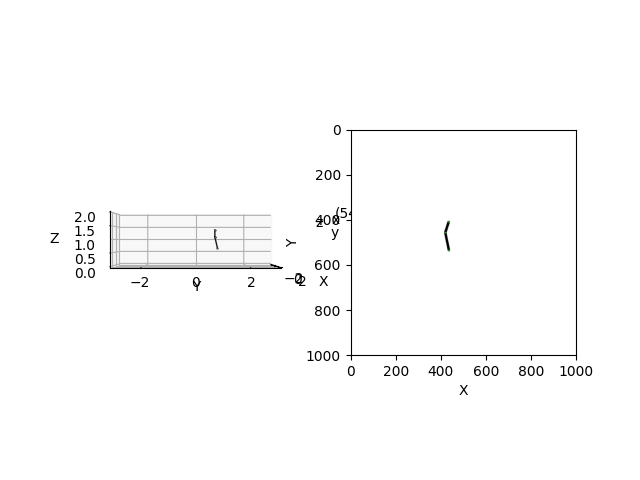

In [298]:
frame_num = 50
limb = limb_trajectory[frame_num]

%matplotlib widget
fig = plt.figure(3)
fig.clear()
ax = axes_3d(fig, loc=121,
             xlim=(-3, 3), ylim=(-3, 3), zlim=(0, 2))
ax.set_zlim(0, 2)
ax.set_aspect('equal', 'box')
draw_3d_pose(ax, limb, dataset='limb')
cam_frame_54138969.draw3d()
ax2 = axes_2d(fig, loc=122)
img = get_2d_pose_image(limb_trajectory_projected[frame_num], H=1000, W=1000, dataset='limb')
ax2.imshow(img)

plt.show()

In [289]:
cam_54138969_int, cam_54138969_ext

({'calibration_matrix': [[1145.04940458804, 0.0, 512.541504956548],
   [0.0, 1143.78109572365, 515.4514869776],
   [0.0, 0.0, 1.0]],
  'distortion': [-0.207098910824901,
   0.247775183068982,
   -0.00142447157470321,
   -0.000975698859470499,
   -0.00307515035078854]},
 {'R': [[-0.9153617321513369, 0.40180836633680234, 0.02574754463350265],
   [0.051548117060134555, 0.1803735689384521, -0.9822464900705729],
   [-0.399319034032262, -0.8977836111057917, -0.185819527201491]],
  't': [[-346.05078140028075], [546.9807793144001], [5474.481087434061]]})

In [337]:
camera_id = '54138969'

data = {}
for key in ['joint_2d', 'confidence', 'joint3d_image', 'joints_2.5d_image', '2.5d_factor', 'camera_name', 'action', 'source', 'frame', 'world_3d', 'cam_3d', 'cam_param']:
    data[key] = []

calibration_matrix = np.array(cam_param[camera_id]['int']['calibration_matrix'])
R = np.array(cam_param[camera_id]['ext']['R'])
t = np.array(cam_param[camera_id]['ext']['t']) * 0.001
camera_param = {
    'intrinsic': calibration_matrix,
    'extrinsic': np.concatenate([R, t.reshape(3, 1)], axis=1),
}

fx = camera_param['intrinsic'][0, 0]  
fy = camera_param['intrinsic'][1, 1]  
cx = camera_param['intrinsic'][0, 2]  
cy = camera_param['intrinsic'][1, 2] 

for frame_num in tqdm(range(len(limb_trajectory))):
    # joint3d_image
    world_3d = np.array(limb_trajectory[frame_num])

    # world to camera
    pos = copy.deepcopy(world_3d)
    cam_3d = World2CameraCoordinate(pos, camera_param['extrinsic']) # World coordinate -> Camera coordinate
    cam_3d_hat = get_rootrel_pose(cam_3d)

    # camera to image
    box = infer_box(cam_3d, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
    img_2d, img_3d = camera_to_image_frame(cam_3d, box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
    #img_2d_hat = get_rootrel_pose(img_2d) # (17, 2) # root-relative pose 
    img_3d_hat = get_rootrel_pose(img_3d) # (17, 3) # root-relative pose 

    # 2.5d factor
    pred_lambda, losses = optimize_scaling_factor(img_3d_hat, cam_3d_hat, stop_tolerance=0.0001) # x,y,z 사용
    #print('pred_lambda:', pred_lambda)
    #print('losses:', losses)

    # joint 2.5d image
    img_25d = img_3d * pred_lambda
    #img_25d_hat = get_rootrel_pose(img_25d)

    # store
    data['joint_2d'].append(np.array(img_2d).copy()) 
    data['confidence'].append(np.ones(17)) 
    data['joint3d_image'].append(np.array(img_3d).copy()) 
    data['joints_2.5d_image'].append(np.array(img_25d).copy()) 
    data['2.5d_factor'].append(np.array(pred_lambda).copy()) 
    data['camera_name'].append(np.array(camera_id).copy()) 
    data['action'].append(np.array(action).copy()) 
    #data['source'].append(np.array(source).copy()) 
    data['frame'].append(np.array(frame_num).copy()) 
    data['world_3d'].append(np.array(world_3d).copy()) 
    data['cam_3d'].append(np.array(cam_3d).copy()) 
    data['cam_param'].append(np.array(camera_param).copy()) 

  0%|          | 0/243 [00:00<?, ?it/s]

100%|██████████| 243/243 [00:01<00:00, 134.38it/s]


[0, 1]
[1, 2]


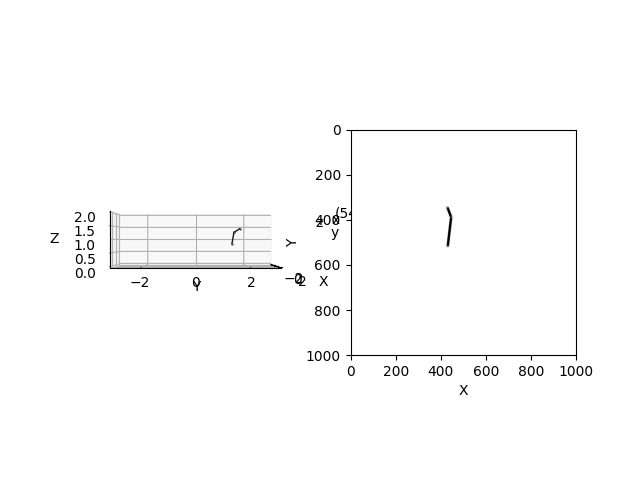

In [340]:
%matplotlib widget
fig = plt.figure(3)
fig.clear()
ax = axes_3d(fig, loc=121,
             xlim=(-3, 3), ylim=(-3, 3), zlim=(0, 2))
ax.set_zlim(0, 2)
ax.set_aspect('equal', 'box')
draw_3d_pose(ax, world_3d, dataset='limb')
draw_3d_pose(ax, img_3d, dataset='limb')

cam_frame_54138969.draw3d()
ax2 = axes_2d(fig, loc=122)
img = get_2d_pose_image(img_2d, H=1000, W=1000, dataset='limb')
ax2.imshow(img)
ax2.plot(box[0], box[1], 'r-')
plt.show()

### generate pkl for each sample

In [10]:
# sampling 
seed = 0
random.seed(seed)
total_num_data = 10000

camera_param = {}
for camera_id in ['54138969', '55011271', '58860488', '60457274']:
    calibration_matrix = np.array(cam_param[camera_id]['int']['calibration_matrix'])
    R = np.array(cam_param[camera_id]['ext']['R'])
    t = np.array(cam_param[camera_id]['ext']['t']) * 0.001
    camera_param[camera_id] = {
        'intrinsic': calibration_matrix,
        'extrinsic': np.concatenate([R, t.reshape(3, 1)], axis=1),
        'fx': calibration_matrix[0, 0],
        'fy': calibration_matrix[1, 1],
        'cx': calibration_matrix[0, 2],
        'cy': calibration_matrix[1, 2],
    }

save_folder = '/home/hrai/codes/MotionBERT/data/motion3d/random_limb_pkl'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

for i in tqdm(range(total_num_data)):
    save_path = save_folder + '/seed{}_{}.pkl'.format(seed, i)

    data = {}
    for key in ['joint_2d', 'confidence', 'joint3d_image', 'joints_2.5d_image', '2.5d_factor', 'camera_name', 'action', 'source', 'frame', 'world_3d', 'cam_3d', 'cam_param']:
        data[key] = []

    root_point_traj_num = random.randint(0, len(root_point_traj_list)-1)
    upper_vector_traj_num = random.randint(0, len(upper_vector_traj_list)-1)
    under_vector_traj_num = random.randint(0, len(under_vector_traj_list)-1)

    root_point_start_idx = random.randint(0, len(root_point_traj_list)-243)
    upper_vector_start_idx = random.randint(0, len(upper_vector_traj_list)-243)
    under_vector_start_idx = random.randint(0, len(under_vector_traj_list)-243)

    if os.path.exists(save_path): continue # locate here to keep the randoom seed consistent

    root_point_traj = root_point_traj_list[root_point_traj_num][root_point_start_idx:root_point_start_idx+243]
    upper_vector_traj = upper_vector_traj_list[upper_vector_traj_num][upper_vector_start_idx:upper_vector_start_idx+243] + root_point_traj
    under_vector_traj = under_vector_traj_list[under_vector_traj_num][under_vector_start_idx:under_vector_start_idx+243] + upper_vector_traj

    limb_trajectory = np.stack([root_point_traj, upper_vector_traj, under_vector_traj], axis=1)
    
    for camera_id in ['54138969', '55011271', '58860488', '60457274']:
        fx = camera_param[camera_id]['fx']
        fy = camera_param[camera_id]['fy']
        cx = camera_param[camera_id]['cx']
        cy = camera_param[camera_id]['cy']
        for frame_num in range(len(limb_trajectory)):
            # joint3d_image
            world_3d = np.array(limb_trajectory[frame_num])

            # world to camera
            pos = copy.deepcopy(world_3d)
            cam_3d = World2CameraCoordinate(pos, camera_param[camera_id]['extrinsic']) # World coordinate -> Camera coordinate
            cam_3d_hat = get_rootrel_pose(cam_3d)

            # camera to image
            box = infer_box(cam_3d, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
            img_2d, img_3d = camera_to_image_frame(cam_3d, box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
            #img_2d_hat = get_rootrel_pose(img_2d) # (3, 2) # root-relative pose 
            img_3d_hat = get_rootrel_pose(img_3d) # (3, 3) # root-relative pose 

            # 2.5d factor
            pred_lambda, losses = optimize_scaling_factor(img_3d_hat, cam_3d_hat, stop_tolerance=0.0001) # x,y,z 사용

            # joint 2.5d image
            img_25d = img_3d * pred_lambda
            #img_25d_hat = get_rootrel_pose(img_25d)

            source = 'seed{}_{}'.format(seed, i)

            # store
            data['joint_2d'].append(np.array(img_2d).copy()) 
            data['confidence'].append(np.ones(3)) 
            data['joint3d_image'].append(np.array(img_3d).copy()) 
            data['joints_2.5d_image'].append(np.array(img_25d).copy()) 
            data['2.5d_factor'].append(np.array(pred_lambda).copy()) 
            data['camera_name'].append(np.array(camera_id).copy()) 
            data['action'].append(np.array(action).copy()) 
            data['source'].append(np.array(source).copy()) 
            data['frame'].append(np.array(frame_num).copy()) 
            data['world_3d'].append(np.array(world_3d).copy()) 
            data['cam_3d'].append(np.array(cam_3d).copy()) 
            data['cam_param'].append(np.array(camera_param[camera_id]).copy()) 

    # save
    savepkl(data, save_path)

  0%|          | 0/10000 [00:00<?, ?it/s]

 40%|████      | 4000/10000 [12:38:24<18:57:36, 11.38s/it]


KeyboardInterrupt: 

### Check pkls by generating videos

In [11]:
for item in glob('/home/hrai/codes/MotionBERT/data/motion3d/random_limb_pkl/seed*_*.pkl'):
    data = readpkl(item)
    seed = int(item.split('/')[-1].split('_')[0][4:])
    num = int(item.split('/')[-1].split('_')[1].split('.')[0])
    print(seed, num)
    video_path = '/home/hrai/codes/MotionBERT/custom_codes/DHDST/seed{}_{}.mp4'.format(seed, num)
    if os.path.exists(video_path): continue
    print(np.array(data['joint_2d']).shape)
    save_h36m_pose_video(np.array(data['joint_2d']), video_path, dataset='limb', W=1000, H=1000, pose_type='2d', fps=30,
                            xlim=(-1, 1), ylim=(-1, 1), zlim=(0, 2), view=(0, 45),
                            centered_xy=False, cam_space=False, on_ground=False, refine_tilt=False,  
                            dynamic_view=False, dual_view=False,
                            imgs=None,
                            show_axis=False)

0 1620
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6617b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 91.85it/s] 


0 546
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6bfcb40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 93.02it/s] 


0 1222
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6741b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:09<00:00, 99.47it/s] 


0 1296
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5e00b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 89.86it/s] 


0 1509
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6646b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 96.60it/s] 


0 359
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x633db40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 89.56it/s] 


0 1209
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x59d3b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 91.97it/s] 


0 2009
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7262b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 94.52it/s] 


0 3926
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7468b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 90.42it/s] 


0 2952
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5ce6b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 94.26it/s] 


0 3069
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5727b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 96.24it/s] 


0 799
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x585fb40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 96.78it/s] 


0 2918
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5a60b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 93.59it/s] 


0 3337
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x570cb40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 93.78it/s] 


0 2574
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5d36b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 93.16it/s] 


0 3479
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x65bfb40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 93.26it/s] 


0 205
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6e9eb40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 93.99it/s] 


0 2709
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x61eeb40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 94.51it/s] 


0 2188
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7042b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 90.47it/s] 


0 1316
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x70a1b40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 92.22it/s] 
/home/hrai/codes/PoseAdaptor/my_utils/visualization.py:451: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


0 1686
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x60cbb40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 92.76it/s] 


0 3080
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5fabb40] Warning: data is not aligned! This can lead to a speed loss
 91%|█████████ | 881/972 [00:09<00:01, 89.41it/s] Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f53231c6fd0>>
Traceback (most recent call last):
  File "/home/hrai/miniconda3/envs/motionbert/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
100%|██████████| 972/972 [00:10<00:00, 92.00it/s] 


0 587
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6a8ab40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 972/972 [00:10<00:00, 94.97it/s] 


0 637
(972, 3, 2)


  0%|          | 0/972 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x554ab40] Warning: data is not aligned! This can lead to a speed loss
 23%|██▎       | 226/972 [00:02<00:07, 103.47it/s]

### generate total pkl

In [7]:
# split train/test 
pkl_folder = '/home/hrai/codes/MotionBERT/data/motion3d/random_limb_pkl/'
random.seed(0)
l = [x for x in range(len(os.listdir(pkl_folder)))][:2000]
random.shuffle(l)
train_list = l[:int(len(l)*0.8)]
test_list = l[int(len(l)*0.8):]
print(len(train_list), len(test_list), train_list[:5], test_list[:5])

1600 400 [1748, 1361, 1671, 865, 1288] [390, 200, 1921, 1082, 1383]


In [11]:
joint_2ds = {'train': [], 'test': []}
confidences = {'train': [], 'test': []}
joint3d_images = {'train': [], 'test': []}
joints_25d_images = {'train': [], 'test': []}
_25d_factors = {'train': [], 'test': []}
camera_names = {'train': [], 'test': []}
actions = {'train': [], 'test': []}
sources = {'train': [], 'test': []}
frames = {'train': [], 'test': []}
world_3ds = {'train': [], 'test': []}
cam_3ds = {'train': [], 'test': []}
cam_params = {'train': [], 'test': []}

# target 

#action_list = ['squat', 'pushup', 'kneeup', 'benchpress', 'burpee', 'cat', 'yoga']
#test_subject = ['S12', 'S15', 'S18'] # ['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10']
#camera_list = [1, 2, 3, 4, 5] # [1, 2, 3, 4, 5]
# pelvis, r_hip, l_hip, torso, neck, l_shoulder, r_shoulder = 0, 1, 4, 7, 8, 11, 14
# r_knee, r_ankle, l_knee, l_ankle = 2, 3, 5, 6
# l_elbow, l_wrist, r_elbow, r_wrist = 12, 13, 15, 16
# joint_list = [j for j in range(17)] # [r_knee, r_ankle, l_knee, l_ankle, l_elbow, l_wrist, r_elbow, r_wrist] # [j for j in range(17)]
only_test = False

blacklist = []

for item in tqdm(os.listdir(pkl_folder)):
    seed, num = item.split('.')[0].split('seed')[1].split('_')
    #print(seed, num)
    # filtering
    #if action not in action_list: continue 
    #if int(cam_num) not in camera_list: continue
    #if only_test:
    #    if subject not in test_subject: continue
    #if subject in blacklist: continue
    #print(subject, cam_num, action, phase) 
    
    if int(num) in test_list: data_type = 'test'
    elif int(num) in train_list: data_type = 'train'
    else: continue 
    
    item_path = os.path.join(pkl_folder, item) 
    data = readpkl(item_path) 
    
    joint_2ds[data_type] += list(np.array(data['joint_2d'])) 
    confidences[data_type] += list(np.array(data['confidence'])) 
    joint3d_images[data_type] += list(np.array(data['joint3d_image'])) 
    joints_25d_images[data_type] += list(np.array(data['joints_2.5d_image'])) 
    _25d_factors[data_type] += data['2.5d_factor'] 
    camera_names[data_type] += data['camera_name']  
    actions[data_type] += data['action'] 
    sources[data_type] += data['source'] 
    frames[data_type] += data['frame'] 
    world_3ds[data_type] += list(np.array(data['world_3d'])) 
    cam_3ds[data_type] += list(np.array(data['cam_3d']))
    cam_params[data_type] += data['cam_param'] 
    
kookmin_total = {'train': {}, 'test': {}}

for data_type in ['train', 'test']:
    kookmin_total[data_type]['joint_2d']          = copy.deepcopy(np.array(joint_2ds[data_type]))
    kookmin_total[data_type]['confidence']        = copy.deepcopy(np.array(confidences[data_type]))
    kookmin_total[data_type]['joint3d_image']     = copy.deepcopy(np.array(joint3d_images[data_type]))
    kookmin_total[data_type]['joints_2.5d_image'] = copy.deepcopy(np.array(joints_25d_images[data_type]))
    kookmin_total[data_type]['2.5d_factor']       = copy.deepcopy(np.array(_25d_factors[data_type]))
    kookmin_total[data_type]['camera_name']       = copy.deepcopy(np.array(camera_names[data_type]))
    kookmin_total[data_type]['action']            = copy.deepcopy(np.array(actions[data_type]))
    kookmin_total[data_type]['source']            = copy.deepcopy(np.array(sources[data_type]))
    kookmin_total[data_type]['frame']             = copy.deepcopy(np.array(frames[data_type]))
    kookmin_total[data_type]['world_3d']          = copy.deepcopy(np.array(world_3ds[data_type]))
    kookmin_total[data_type]['cam_3d']            = copy.deepcopy(np.array(cam_3ds[data_type]))
    kookmin_total[data_type]['cam_param']         = copy.deepcopy(np.array(cam_params[data_type]))
    
# if len(kookmin_total['train']['joint_2d']) == 0:
#     kookmin_total['train'] = copy.deepcopy(kookmin_total['test'])

kookmin_total['train']['joint3d_image'].shape, kookmin_total['test']['joint3d_image'].shape  

100%|██████████| 4000/4000 [00:49<00:00, 80.11it/s] 


((1555200, 3, 3), (388800, 3, 3))

In [12]:
kookmin_total['test']['confidence'].shape, kookmin_total['test']['source'].shape

((388800, 3), (388800,))

In [13]:
user = getpass.getuser()
motionbert_root = '/home/{}/codes/MotionBERT'.format(user)
save_path = os.path.join(motionbert_root, 'data/motion3d/random_limb_train{}_test{}.pkl'.format(len(train_list), len(test_list)))
savepkl(kookmin_total, save_path)

In [15]:
kookmin_total['train'].keys()

dict_keys(['joint_2d', 'confidence', 'joint3d_image', 'joints_2.5d_image', '2.5d_factor', 'camera_name', 'action', 'source', 'frame', 'world_3d', 'cam_3d', 'cam_param'])

In [16]:
kookmin_total['train']['joints_2.5d_image'][0]

array([[1.92123161, 1.35774198, 0.        ],
       [1.95684887, 1.85142271, 0.08006528],
       [1.81702749, 2.26153837, 0.2461267 ]])

In [19]:
1/kookmin_total['train']['2.5d_factor'][0]

237.21360842147308

In [20]:
kookmin_total['train']['joints_2.5d_image'][0] / kookmin_total['train']['2.5d_factor'][0]

array([[455.74228318, 322.07487359,   0.        ],
       [464.19118122, 439.18266141,  18.99257455],
       [431.02364755, 536.46767742,  58.38460334]])

In [17]:
kookmin_total['train']['joint3d_image'][0]

array([[455.74228318, 322.07487359,   0.        ],
       [464.19118122, 439.18266141,  18.99257455],
       [431.02364755, 536.46767742,  58.38460334]])